Approach 1: Final Test Set Evaluation

Loads full SavedModels and evaluates on HELD-OUT test set.

In [18]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')



In [19]:
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, 'saved_models')
TEST_SET_DIR = '../data/approach1/test_set'
INVENTORY_PATH = os.path.join(RESULTS_DIR, 'full_model_inventory.csv')
YAMNET_URL = 'https://tfhub.dev/google/yamnet/1'

os.makedirs(RESULTS_DIR, exist_ok=True)

In [20]:
# LOAD TEST SET (Y_LABELS)
y_test = np.load(os.path.join(TEST_SET_DIR, 'y_test.npy'))  # string labels

print(f"Test samples: {len(y_test):,}")

# REGENERATE RAW TEST AUDIO FROM FRAME .NPY FILES (15,360 samples @ 16kHz)
# Load test frame paths
frame_paths_path = os.path.join(TEST_SET_DIR, 'test_frame_paths.npy')
if not os.path.exists(frame_paths_path):
    raise FileNotFoundError(f"Missing test_frame_paths.npy - Run 02_classifier_training_evaluation.py first to generate it!")

test_frame_paths = np.load(frame_paths_path, allow_pickle=True)
print(f"Loading {len(test_frame_paths)} frame .npy files...")

# Load each .npy (raw audio frame)
raw_audio_list = []
target_length = 15360  # 0.96s @ 16kHz

for frame_path in test_frame_paths:
    if not os.path.exists(frame_path):
        print(f"  Missing file: {frame_path}")
        continue
    try:
        audio = np.load(frame_path)
        if audio.ndim > 1:
            audio = audio.flatten()  # Ensure 1D
        if len(audio) != target_length:
            print(f"  Wrong shape: {len(audio)} - Skipping {frame_path}")
            continue
        raw_audio_list.append(audio)
    except Exception as e:
        print(f"  Error loading {frame_path}: {e}")

X_test_raw = np.array(raw_audio_list).astype(np.float32)
print(f"Raw audio reconstructed: {X_test_raw.shape}")  # → (1420, 15360)

# Validate against y_test
if len(X_test_raw) != len(y_test):
    raise ValueError(f"Mismatch: Raw audio {len(X_test_raw)} vs labels {len(y_test)} - Check file paths")

# SAVE FOR FUTURE (optional)
raw_save_path = os.path.join(TEST_SET_DIR, 'X_test_raw_audio.npy')
np.save(raw_save_path, X_test_raw)
print(f"Raw audio saved: {raw_save_path}")


# LOAD LABEL ENCODER
label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
classes = label_encoder.classes_
print(f"Classes ({len(classes)}): {', '.join(classes)}")

# Encode labels
y_test_encoded = label_encoder.transform(y_test)


Test samples: 1,420
Loading 1420 frame .npy files...
Raw audio reconstructed: (1420, 15360)
Raw audio saved: ../data/approach1/test_set\X_test_raw_audio.npy
Classes (5): Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren


In [21]:
# LOAD FULL MODELS

inventory_df = pd.read_csv(INVENTORY_PATH)
model_paths = {}

for _, row in inventory_df.iterrows():
    model_name = row['Model']
    path = row['Path']
    if os.path.exists(path):
        model_paths[model_name] = path
        print(f"  Loaded: {model_name}")
    else:
        print(f"  Missing: {model_name} at {path}")

print(f"\nFound {len(model_paths)} full models")

# INFERENCE FUNCTION

def run_inference(model, audio_batch):
    """Run inference on batch of 0.96s audio clips"""
    start = time.time()
    probs = model.predict(audio_batch, verbose=0)
    latency_ms = (time.time() - start) * 1000 / len(audio_batch)
    return probs, latency_ms


# EVALUATE ALL MODELS

print("\nRUNNING INFERENCE ON TEST SET")

results = []
all_predictions = {}
all_probabilities = {}

for model_name, model_path in model_paths.items():
    print(f"\nEvaluating: {model_name}")
    
    # Load model
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'KerasLayer': hub.KerasLayer}
        )
        print(f"  Model loaded")
    except Exception as e:
        print(f"  Failed to load: {e}")
        continue

    # Run inference
    probs, latency_ms = run_inference(model, X_test_raw.astype(np.float32))
    y_pred = np.argmax(probs, axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Metrics
    acc = accuracy_score(y_test_encoded, y_pred)
    f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
    f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='macro')
    recall = recall_score(y_test_encoded, y_pred, average='macro')

    # Size
    size_mb = inventory_df[inventory_df['Model'] == model_name]['Size_MB'].values[0]

    results.append({
        'Model': model_name,
        'Accuracy': round(acc, 4),
        'F1_Macro': round(f1_macro, 4),
        'F1_Weighted': round(f1_weighted, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Latency_ms_per_sample': round(latency_ms, 2),
        'Size_MB': size_mb
    })

    all_predictions[model_name] = y_pred_labels
    all_probabilities[model_name] = probs

    print(f"  Accuracy: {acc:.4f} | F1: {f1_macro:.4f} | Latency: {latency_ms:.2f} ms/sample")


  Loaded: XGBoost
  Loaded: MLP
  Loaded: Random_Forest
  Loaded: SVM
  Loaded: Logistic_Regression

Found 5 full models

RUNNING INFERENCE ON TEST SET

Evaluating: XGBoost
  Model loaded
  Accuracy: 0.9239 | F1: 0.9239 | Latency: 7.47 ms/sample

Evaluating: MLP
  Model loaded
  Accuracy: 0.9282 | F1: 0.9290 | Latency: 7.29 ms/sample

Evaluating: Random_Forest
  Model loaded
  Accuracy: 0.9324 | F1: 0.9327 | Latency: 6.61 ms/sample

Evaluating: SVM
  Model loaded
  Accuracy: 0.9430 | F1: 0.9431 | Latency: 6.73 ms/sample

Evaluating: Logistic_Regression
  Model loaded
  Accuracy: 0.9183 | F1: 0.9187 | Latency: 6.48 ms/sample


In [22]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Macro', ascending=False)

print("\n" + results_df[['Model', 'F1_Macro', 'Accuracy', 'Latency_ms_per_sample', 'Size_MB']].to_string(index=False))

# Save
leaderboard_path = os.path.join(RESULTS_DIR, 'final_test_leaderboard.csv')
results_df.to_csv(leaderboard_path, index=False)
print(f"\nLeaderboard saved: {leaderboard_path}")



              Model  F1_Macro  Accuracy  Latency_ms_per_sample  Size_MB
                SVM    0.9431    0.9430                   6.73      3.5
      Random_Forest    0.9327    0.9324                   6.61      3.5
                MLP    0.9290    0.9282                   7.29      3.5
            XGBoost    0.9239    0.9239                   7.47      3.5
Logistic_Regression    0.9187    0.9183                   6.48      3.6

Leaderboard saved: ../results/results_approach1\final_test_leaderboard.csv



GENERATING CONFUSION MATRICES
Confusion matrices saved: ../results/results_approach1\final_test_confusion_matrices.png


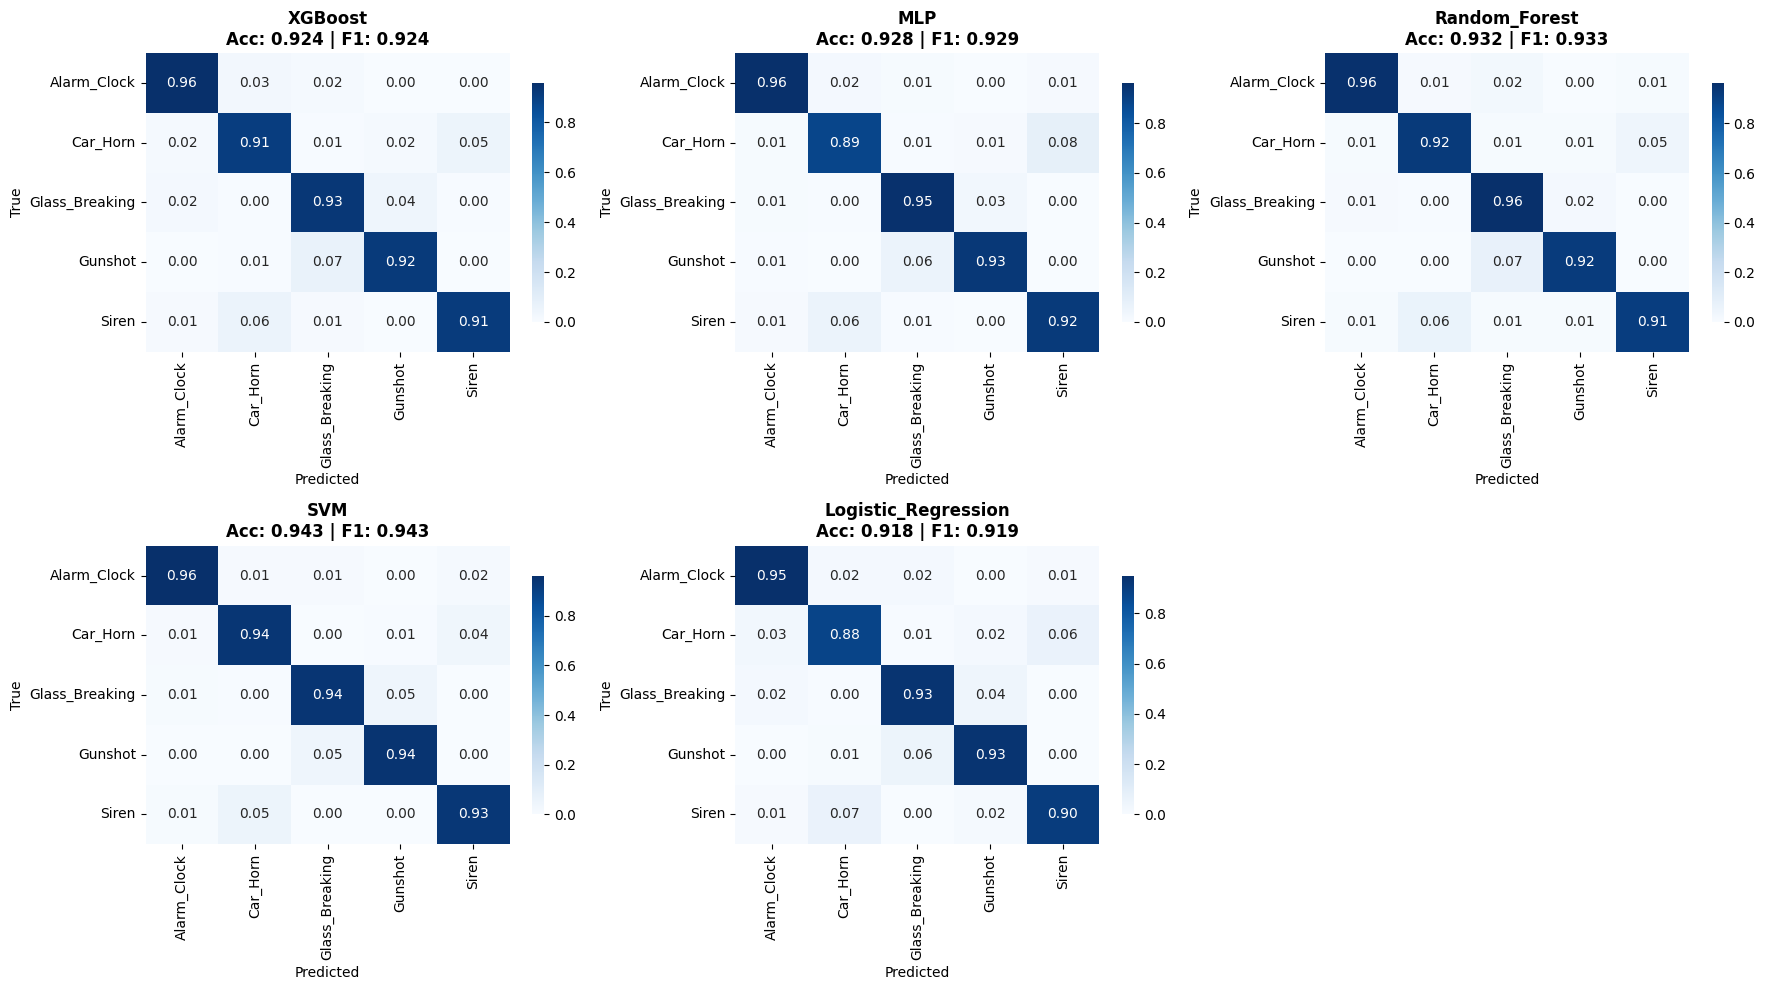

In [23]:

print("\nGENERATING CONFUSION MATRICES")


n_models = len(all_predictions)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                ax=axes[idx], cbar_kws={'shrink': 0.8})
    
    acc = results_df[results_df['Model'] == model_name]['Accuracy'].values[0]
    f1 = results_df[results_df['Model'] == model_name]['F1_Macro'].values[0]
    axes[idx].set_title(f'{model_name}\nAcc: {acc:.3f} | F1: {f1:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

for j in range(len(all_predictions), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, 'final_test_confusion_matrices.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrices saved: {cm_path}")
plt.show()



GENERATING ROC CURVES
ROC curves saved: ../results/results_approach1\final_test_roc_curves.png


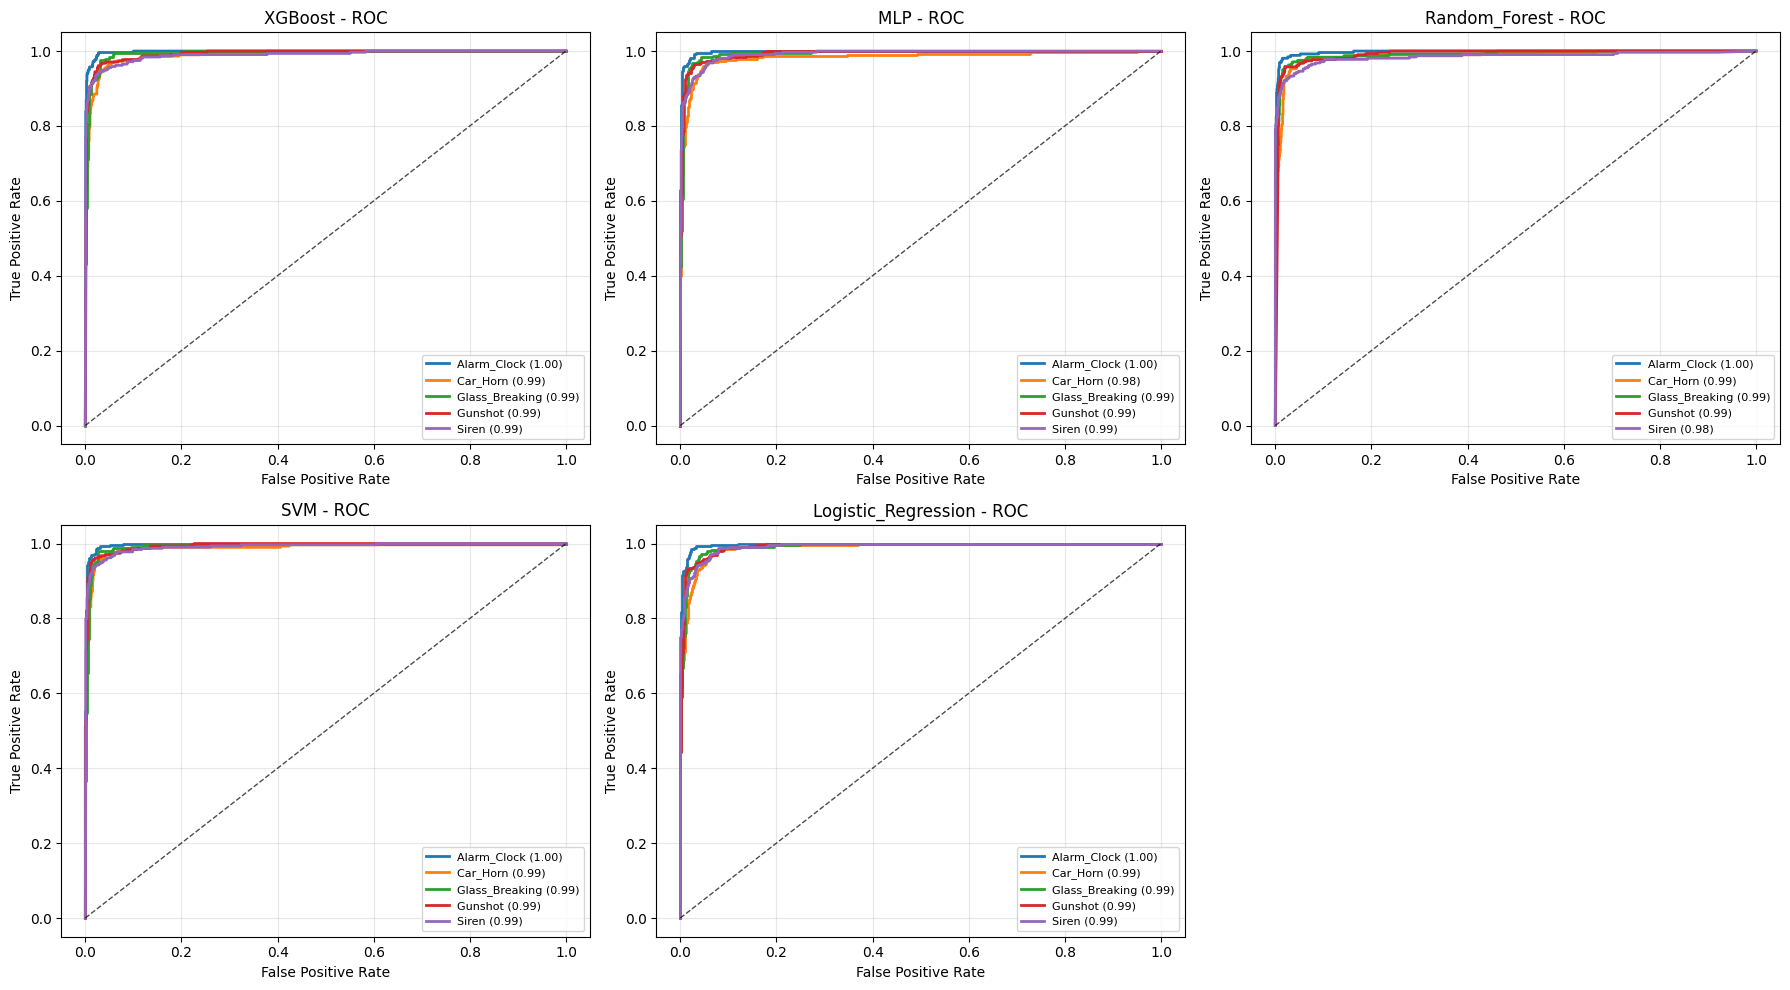

In [24]:
# ROC CURVES

print("\nGENERATING ROC CURVES")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, probs) in enumerate(all_probabilities.items()):
    for i, class_name in enumerate(classes):
        y_binary = (y_test_encoded == i).astype(int)
        fpr, tpr, _ = roc_curve(y_binary, probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[idx].plot(fpr, tpr, lw=2, label=f'{class_name} ({roc_auc:.2f})')
    
    axes[idx].plot([0,1], [0,1], 'k--', lw=1, alpha=0.7)
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{model_name} - ROC')
    axes[idx].legend(fontsize=8, loc='lower right')
    axes[idx].grid(alpha=0.3)

for j in range(len(all_probabilities), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
roc_path = os.path.join(RESULTS_DIR, 'final_test_roc_curves.png')
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"ROC curves saved: {roc_path}")
plt.show()



PER-CLASS F1 SCORES
Per-class F1 saved: ../results/results_approach1\final_per_class_f1.png


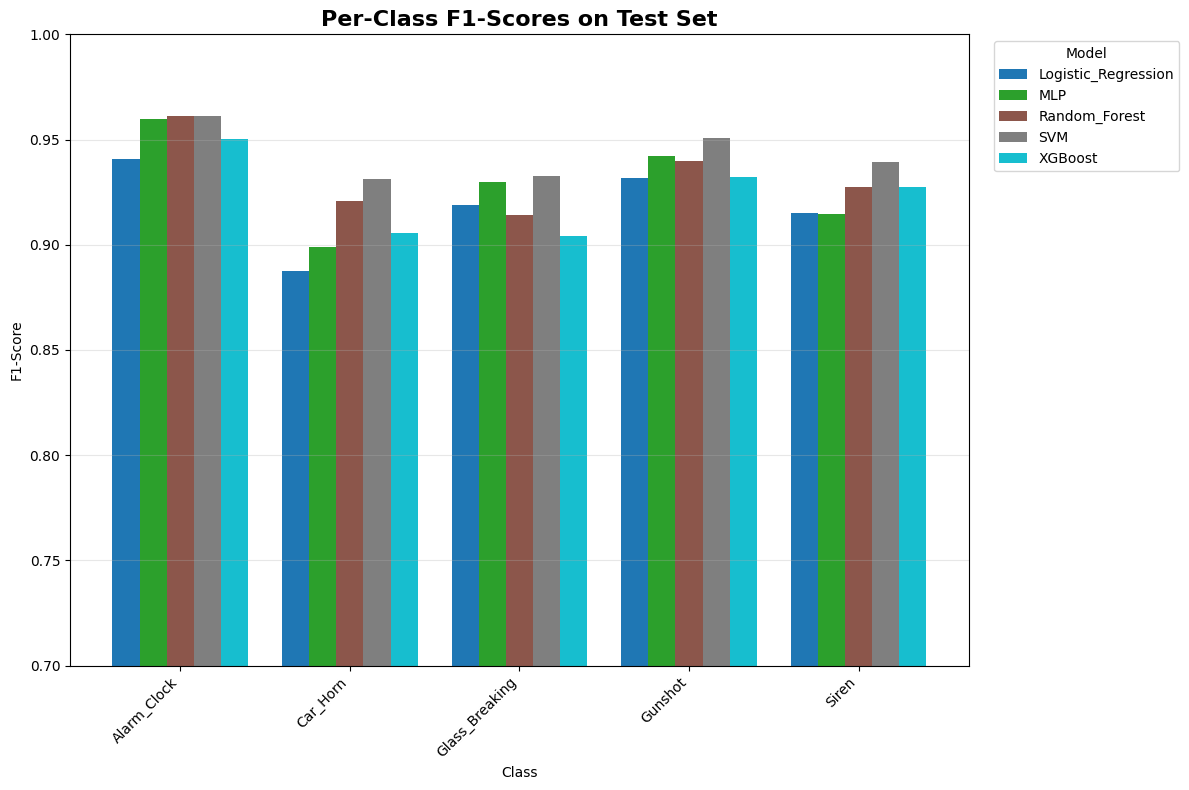

In [25]:
# PER-CLASS F1

print("\nPER-CLASS F1 SCORES")

per_class_data = []
for model_name, y_pred in all_predictions.items():
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    for cls in classes:
        per_class_data.append({
            'Model': model_name,
            'Class': cls,
            'F1': report[cls]['f1-score'],
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'Support': int(report[cls]['support'])
        })

per_class_df = pd.DataFrame(per_class_data)
pivot_f1 = per_class_df.pivot(index='Class', columns='Model', values='F1')

plt.figure(figsize=(12, 8))
pivot_f1.plot(kind='bar', ax=plt.gca(), width=0.8, cmap='tab10')
plt.title('Per-Class F1-Scores on Test Set', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score')
plt.xlabel('Class')
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
per_class_path = os.path.join(RESULTS_DIR, 'final_per_class_f1.png')
plt.savefig(per_class_path, dpi=300, bbox_inches='tight')
print(f"Per-class F1 saved: {per_class_path}")
plt.show()




PERFORMANCE vs SIZE & LATENCY
Tradeoff plot saved: ../results/results_approach1\final_tradeoff_analysis.png


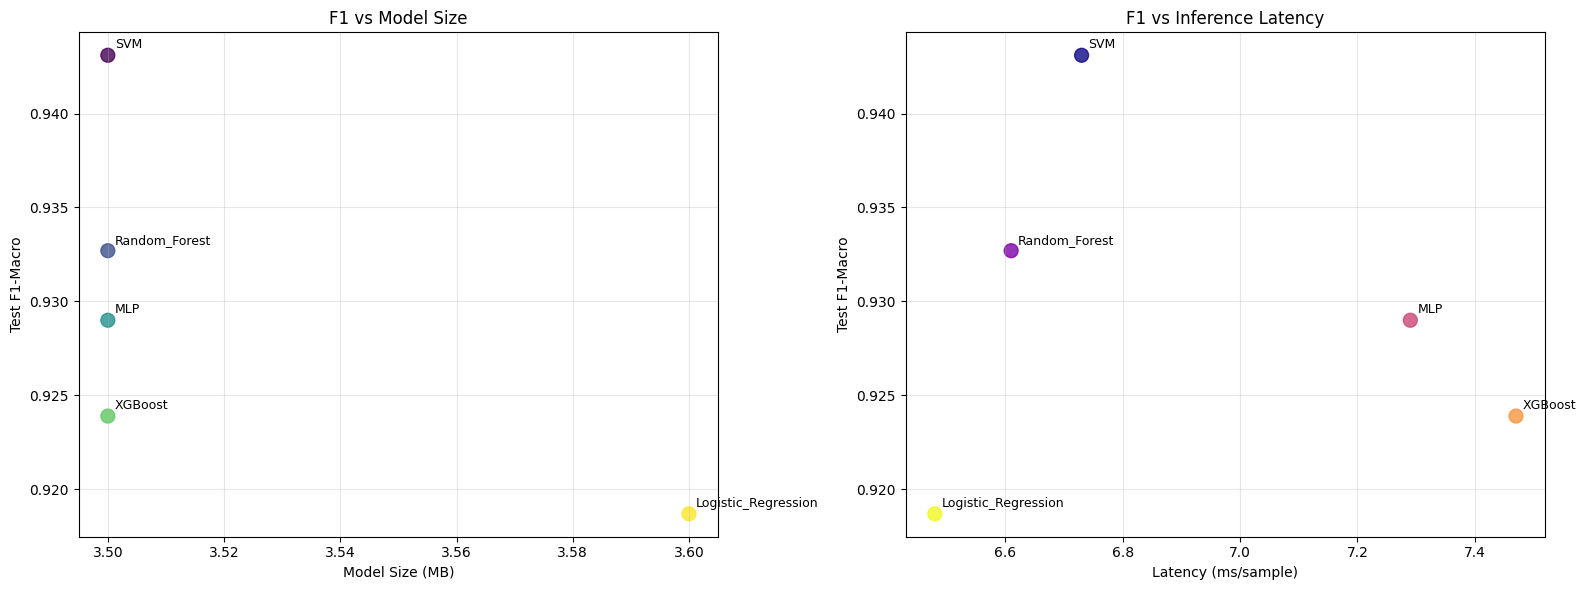

In [26]:
# PERFORMANCE vs SIZE & LATENCY

print("\nPERFORMANCE vs SIZE & LATENCY")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Size
sizes = results_df['Size_MB']
f1s = results_df['F1_Macro']
models = results_df['Model']

ax1.scatter(sizes, f1s, s=100, c=range(len(models)), cmap='viridis', alpha=0.8)
for i, model in enumerate(models):
    ax1.annotate(model, (sizes.iloc[i], f1s.iloc[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Model Size (MB)')
ax1.set_ylabel('Test F1-Macro')
ax1.set_title('F1 vs Model Size')
ax1.grid(alpha=0.3)

# F1 vs Latency
latency = results_df['Latency_ms_per_sample']
ax2.scatter(latency, f1s, s=100, c=range(len(models)), cmap='plasma', alpha=0.8)
for i, model in enumerate(models):
    ax2.annotate(model, (latency.iloc[i], f1s.iloc[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Latency (ms/sample)')
ax2.set_ylabel('Test F1-Macro')
ax2.set_title('F1 vs Inference Latency')
ax2.grid(alpha=0.3)

plt.tight_layout()
tradeoff_path = os.path.join(RESULTS_DIR, 'final_tradeoff_analysis.png')
plt.savefig(tradeoff_path, dpi=300, bbox_inches='tight')
print(f"Tradeoff plot saved: {tradeoff_path}")
plt.show()




In [27]:
# FINAL REPORT

best_model = results_df.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"  Test F1-Macro: {best_model['F1_Macro']:.4f}")
print(f"  Test Accuracy: {best_model['Accuracy']:.4f}")
print(f"  Latency: {best_model['Latency_ms_per_sample']:.2f} ms/sample")
print(f"  Size: {best_model['Size_MB']:.1f} MB")

print(f"\nAll results saved in: {RESULTS_DIR}")
print(f"  - final_test_leaderboard.csv")
print(f"  - final_test_confusion_matrices.png")
print(f"  - final_test_roc_curves.png")
print(f"  - final_per_class_f1.png")
print(f"  - final_tradeoff_analysis.png")


BEST MODEL: SVM
  Test F1-Macro: 0.9431
  Test Accuracy: 0.9430
  Latency: 6.73 ms/sample
  Size: 3.5 MB

All results saved in: ../results/results_approach1
  - final_test_leaderboard.csv
  - final_test_confusion_matrices.png
  - final_test_roc_curves.png
  - final_per_class_f1.png
  - final_tradeoff_analysis.png
